# Prepare Working Directory

## Mount the Drive 

In [56]:
from google.colab import drive
drive.mount('/content/drive')

## Change to the Current Working Directory
Make sure you change to the directory where you placed in the drive

In [ ]:
%cd /content/drive/MyDrive/Age and Gender Prediction

In [ ]:
import math

import torch
import torch.nn as nn
from torch.nn.modules.batchnorm import _BatchNorm

import os
import pickle

import numpy as np
import torch.utils.data as data
from PIL import Image

from tools.function import get_pkl_rootpath
import torchvision.transforms as T

In [70]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

# Create Dataset 
Create dataset object for the PETA dataset

In [71]:
# Attributes we are concerned about
FINAL_ATTR_ID = [
  'personalLess30',
  'personalLess45',
  'personalLess60',
  'personalLarger60',
  'personalMale']

In [72]:
class AttrDataset(data.Dataset):

    def __init__(self, split, args, transform=None, target_transform=None):

        data_path = get_pkl_rootpath(args.dataset)

        dataset_info = pickle.load(open(data_path, 'rb+'))

        img_id = dataset_info.image_name
        attr_label = dataset_info.label

        self.dataset = args.dataset
        self.transform = transform
        self.target_transform = target_transform

        self.root_path = dataset_info.root

        self.attr_id = dataset_info.attr_name
        self.attr_num = len(self.attr_id)
        self.final_attr_id = FINAL_ATTR_ID
        self.final_attr_num = len(FINAL_ATTR_ID)

        self.img_idx = dataset_info.partition[split]

        if isinstance(self.img_idx, list):
            self.img_idx = self.img_idx[0] 
        self.img_num = self.img_idx.shape[0]
        self.img_id = [img_id[i] for i in self.img_idx]

        self.label = attr_label[self.img_idx]
        self.final_label = []

        for idx in self.img_idx:
          for i, name in enumerate(self.attr_id):
            temp = []
            if name in self.final_attr_id:
              temp.append(self.label[i])
            self.final_label.append(np.array(temp))
        
        self.final_label = np.array(self.final_label)

    def __getitem__(self, index):
        imgname, gt_label, imgidx = self.img_id[index], self.label[index], self.img_idx[index]
        imgpath = os.path.join(self.root_path, imgname)
        img = Image.open(imgpath)

        if self.transform is not None:
            img = self.transform(img)

        gt_label = gt_label[-5:]

        gt_label = gt_label.astype(np.float32)

        if self.target_transform is not None:
            gt_label = self.transform(gt_label)

        return img, gt_label, imgname

    def __len__(self):
        return len(self.img_id)

In [73]:
def get_transform(args):
    height = args.height
    width = args.width
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    train_transform = T.Compose([
        T.Resize((height, width)),
        T.Pad(10),
        T.RandomCrop((height, width)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        normalize,
    ])

    valid_transform = T.Compose([
        T.Resize((height, width)),
        T.ToTensor(),
        normalize
    ])

    return train_transform, valid_transform

# Model
Define the custom model. The model consists of a resnet backbone encoder followed by a layer to predict the 35 attributes of an image. Using the learnt attributes, it predicts the age and gender of the given image.

In [74]:
# Custom classifer to predict the 35 atributes followed by the age and gender attribute 
class BaseClassifier(nn.Module):
    def __init__(self, nattr):
        super().__init__()
        self.logits = nn.Sequential(
            nn.Linear(2048, nattr),
            nn.BatchNorm1d(nattr)
        )
  
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.final_classifier = nn.Linear(nattr, len(FINAL_ATTR_ID))

    def fresh_params(self):
        return self.parameters()

    def forward(self, feature):
        feat = self.avg_pool(feature).view(feature.size(0), -1)
        x = self.logits(feat)
        x = self.final_classifier(x)
        return x


def initialize_weights(module):
    for m in module.children():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, _BatchNorm):
            m.weight.data.fill_(1)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            stdv = 1. / math.sqrt(m.weight.size(1))
            m.weight.data.uniform_(-stdv, stdv)


class FeatClassifier(nn.Module):

    def __init__(self, backbone, classifier):
        super(FeatClassifier, self).__init__()

        self.backbone = backbone
        self.classifier = classifier

    def fresh_params(self):
        params = self.classifier.fresh_params()
        return params

    def finetune_params(self):
        return self.backbone.parameters()

    def forward(self, x, label=None):
        # Get the RESNET50 embeddings of the given image
        feat_map = self.backbone(x)
        # Pass it through a custom classifier to which predicts the 35 atributes 
        # followed by the age and gender attribute 
        logits = self.classifier(feat_map)
        return logits

# Trainer

In [75]:
import time

import numpy as np
import torch
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

from tools.utils import AverageMeter, to_scalar, time_str

In [76]:
def batch_trainer(epoch, model, train_loader, criterion, optimizer):
    model.train()
    epoch_time = time.time()
    loss_meter = AverageMeter()

    batch_num = len(train_loader)
    gt_list = []
    preds_probs = []

    lr = optimizer.param_groups[1]['lr']

    for step, (imgs, gt_label, imgname) in enumerate(tqdm(train_loader)):

        batch_time = time.time()

        if torch.cuda.is_available():
          imgs, gt_label = imgs.cuda(), gt_label.cuda()

        train_logits = model(imgs, gt_label)
        train_loss = criterion(train_logits, gt_label)

        train_loss.backward()
        # make larger learning rate works
        clip_grad_norm_(model.parameters(), max_norm=10.0)  
        optimizer.step()
        optimizer.zero_grad()
        loss_meter.update(to_scalar(train_loss))

        gt_list.append(gt_label.cpu().numpy())
        train_probs = torch.sigmoid(train_logits)
        preds_probs.append(train_probs.detach().cpu().numpy())

        log_interval = 20
        if (step + 1) % log_interval == 0 or (step + 1) % len(train_loader) == 0:
            print(f'{time_str()}, Step {step}/{batch_num} in Ep {epoch}, {time.time() - batch_time:.2f}s ',
                  f'train_loss:{loss_meter.val:.4f}')

    train_loss = loss_meter.avg

    gt_label = np.concatenate(gt_list, axis=0)
    preds_probs = np.concatenate(preds_probs, axis=0)

    print(f'Epoch {epoch}, LR {lr}, Train_Time {time.time() - epoch_time:.2f}s, Loss: {loss_meter.avg:.4f}')

    return train_loss, gt_label, preds_probs

def valid_trainer(model, valid_loader, criterion):
    model.eval()
    loss_meter = AverageMeter()

    preds_probs = []
    gt_list = []
        
    with torch.no_grad():
        for step, (imgs, gt_label, imgname) in enumerate(tqdm(valid_loader)):

            if torch.cuda.is_available():
              imgs = imgs.cuda()
              gt_label = gt_label.cuda()

            gt_list.append(gt_label.cpu().numpy())
            gt_label[gt_label == -1] = 0
            valid_logits = model(imgs)
            valid_loss = criterion(valid_logits, gt_label)
            valid_probs = torch.sigmoid(valid_logits)
            preds_probs.append(valid_probs.cpu().numpy())
            loss_meter.update(to_scalar(valid_loss))

    valid_loss = loss_meter.avg
    
    gt_label = np.concatenate(gt_list, axis=0)
    preds_probs = np.concatenate(preds_probs, axis=0)
    return valid_loss, gt_label, preds_probs

# Train
Make sure to have PETA dataset is placed in the following format in the `dataset` folder:

`data/PETA/images/PETA.mat/README`

`data/PETA/PETA.mat/`

`data/PETA/README`


In [78]:
import os
import pprint
from collections import OrderedDict, defaultdict

import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from loss.CE_loss import CEL_Sigmoid
from models.resnet import resnet50
from tools.function import get_model_log_path, get_pedestrian_metrics
from tools.utils import time_str, save_ckpt, ReDirectSTD, set_seed

from collections import OrderedDict

set_seed(605)

In [79]:
def load_custom_state_dict(args, model):

    loaded = torch.load(args.pretrained_path, map_location=device)

    if not torch.cuda.is_available():
      new_state_dict = OrderedDict()

      # Remove 'module' if cuda is not there
      for k, v in loaded['state_dicts'].items():
          name = k[7:]
          new_state_dict[name] = v

      # load the parameters
      model.load_state_dict(new_state_dict, strict=False)
    else:      
      model.load_state_dict(loaded['state_dicts'], strict=False)
    
    print("Load successful")
    print(model.eval())

In [80]:
def trainer(epoch, model, train_loader, valid_loader, criterion, optimizer, lr_scheduler,
            path):
    maximum = float(-np.inf)
    best_epoch = 0

    result_list = defaultdict()

    for i in range(epoch):

        train_loss, train_gt, train_probs = batch_trainer(
            epoch=i,
            model=model,
            train_loader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
        )

        valid_loss, valid_gt, valid_probs = valid_trainer(
            model=model,
            valid_loader=valid_loader,
            criterion=criterion,
        )

        lr_scheduler.step(metrics=valid_loss, epoch=i)

        train_result = get_pedestrian_metrics(train_gt, train_probs)
        valid_result = get_pedestrian_metrics(valid_gt, valid_probs)

        print(f'Evaluation on test set, \n',
              'ma: {:.4f},  pos_recall: {:.4f} , neg_recall: {:.4f} \n'.format(
                  valid_result.ma, np.mean(valid_result.label_pos_recall), np.mean(valid_result.label_neg_recall)),
              'Acc: {:.4f}, Prec: {:.4f}, Rec: {:.4f}, F1: {:.4f}'.format(
                  valid_result.instance_acc, valid_result.instance_prec, valid_result.instance_recall,
                  valid_result.instance_f1))

        print(f'{time_str()}')

        cur_metric = valid_result.ma

        if cur_metric > maximum:
            maximum = cur_metric
            best_epoch = i
            save_ckpt(model, path, i, maximum)

        result_list[i] = [train_result, valid_result]

    torch.save(result_list, os.path.join(os.path.dirname(path), 'metric_log.pkl'))

    return maximum, best_epoch

In [81]:
import argparse

parser = argparse.ArgumentParser(description="attribute recognition",
                                  formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("dataset", type=str, default="RAP")
parser.add_argument("--debug", action='store_false')

parser.add_argument("--batchsize", type=int, default=64)
parser.add_argument("--train_epoch", type=int, default=5)
parser.add_argument("--height", type=int, default=256)
parser.add_argument("--width", type=int, default=192)
parser.add_argument("--lr_ft", type=float, default=0.01, help='learning rate of feature extractor')
parser.add_argument("--lr_new", type=float, default=0.1, help='learning rate of classifier_base')
parser.add_argument('--classifier', type=str, default='base', help='classifier name')
parser.add_argument('--momentum', type=float, default=0.9)
parser.add_argument('--weight_decay', type=float, default=5e-4)
parser.add_argument("--train_split", type=str, default="trainval", choices=['train', 'trainval'])
parser.add_argument("--valid_split", type=str, default="test", choices=['test', 'valid'])
parser.add_argument('--device', default=0, type=str, help='gpu device ids for CUDA_VISIBLE_DEVICES')
parser.add_argument("--redirector", action='store_false')
parser.add_argument('--use_bn', action='store_false')
parser.add_argument("--pretrained_path", type=str, default='exp_result/PETA/PETA/img_model/ckpt_max.pth')
args = parser.parse_args(['PETA'])

In [82]:
torch.cuda.empty_cache()

In [ ]:
visenv_name = args.dataset
exp_dir = os.path.join('exp_result', args.dataset)
model_dir, log_dir = get_model_log_path(exp_dir, visenv_name)
stdout_file = os.path.join(log_dir, f'stdout_{time_str()}.txt')
save_model_path = os.path.join(model_dir, 'ckpt_max.pth')

if args.redirector:
    print('redirector stdout')
    ReDirectSTD(stdout_file, 'stdout', False)

pprint.pprint(OrderedDict(args.__dict__))

print(f'use GPU{args.device} for training')
print(f'train set: {args.dataset} {args.train_split}, test set: {args.valid_split}')

train_tsfm, valid_tsfm = get_transform(args)
print(train_tsfm)

train_set = AttrDataset(args=args, split=args.train_split, transform=train_tsfm)

train_loader = DataLoader(
    dataset=train_set,
    batch_size=args.batchsize,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
valid_set = AttrDataset(args=args, split=args.valid_split, transform=valid_tsfm)

valid_loader = DataLoader(
    dataset=valid_set,
    batch_size=args.batchsize,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print(f'{args.train_split} set: {len(train_loader.dataset)}, '
      f'{args.valid_split} set: {len(valid_loader.dataset)}, '
      f'attr_num : {train_set.attr_num}')

labels = train_set.label
sample_weight = labels.mean(0)

backbone = resnet50()
classifier = BaseClassifier(nattr=train_set.attr_num)
model = FeatClassifier(backbone, classifier)

if torch.cuda.is_available():
  model = torch.nn.DataParallel(model).cuda()

if args.pretrained_path is not None:
  load_custom_state_dict(args, model)

criterion = CEL_Sigmoid(sample_weight)

if torch.cuda.is_available():
  param_groups = [{'params': model.module.finetune_params(), 'lr': args.lr_ft},
                  {'params': model.module.fresh_params(), 'lr': args.lr_new}]
else:
  param_groups = [{'params': model.finetune_params(), 'lr': args.lr_ft},
                  {'params': model.fresh_params(), 'lr': args.lr_new}]

optimizer = torch.optim.SGD(param_groups, momentum=args.momentum, weight_decay=args.weight_decay, nesterov=False)
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=4)

best_metric, epoch = trainer(epoch=args.train_epoch,
                              model=model,
                              train_loader=train_loader,
                              valid_loader=valid_loader,
                              criterion=criterion,
                              optimizer=optimizer,
                              lr_scheduler=lr_scheduler,
                              path=save_model_path)

print(f'{visenv_name},  best_metric : {best_metric} in epoch{epoch}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  2%|▏         | 3/179 [02:28<2:18:49, 47.33s/it]

# Validation
Validate the training on the test split of the PETA dataset

In [ ]:
parser = argparse.ArgumentParser(description="attribute recognition prediction",
                                  formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("dataset", type=str, default="RAP")
parser.add_argument("--debug", action='store_false')

parser.add_argument("--batchsize", type=int, default=64)
parser.add_argument("--height", type=int, default=256)
parser.add_argument("--width", type=int, default=192)
parser.add_argument("--test_split", type=str, default="test", choices=['test', 'val'])
parser.add_argument('--device', default=0, type=str, help='gpu device ids for CUDA_VISIBLE_DEVICES')
parser.add_argument("--pretrained_path", type=str, default="exp_result/PETA/PETA/img_model/ckpt_max.pth")

args = parser.parse_args(['PETA'])

In [ ]:
print(f'using GPU{args.device} for testing')
print(f'test set: {args.dataset} {args.test_split}')

train_tsfm, valid_tsfm = get_transform(args)

test_set = AttrDataset(args=args, split=args.test_split, transform=valid_tsfm)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=args.batchsize,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

labels = test_set.label
sample_weight = labels.mean(0)

backbone = resnet50()
classifier = BaseClassifier(nattr=test_set.attr_num)
model = FeatClassifier(backbone, classifier)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model).cuda()

if args.pretrained_path is not None:
    load_custom_state_dict(args, model)

criterion = CEL_Sigmoid(sample_weight)

valid_loss, valid_gt, valid_probs = valid_trainer(
    model=model,
    valid_loader=test_loader,
    criterion=criterion,
)

# Evaluate Metrics
Evaluate the metrics on the predicted test split. The predictions can be found in the `prediction` folder

In [ ]:
import pandas as pd

In [ ]:
valid_loss

2.80375447744081

In [ ]:
stats = get_pedestrian_metrics(valid_gt, valid_probs)
stats

The model acheived 0.87 mean f1 score for all the 5 age and gender attributes

In [ ]:
np.mean(stats['label_f1'])

0.8706162134386461

In [ ]:
COLS = [id + "_pred" for id in FINAL_ATTR_ID] + [id + "_gt" for id in FINAL_ATTR_ID]

In [ ]:
data_pd = np.concatenate((valid_probs, valid_gt), axis=1)
data_pd = np.round_(data_pd, decimals = 1)
data_pd

In [ ]:
df = pd.DataFrame(data=data_pd, columns=COLS)
df.index = test_set.img_id
df.index.name = 'img_id'
df

,personalLess30_pred,personalLess45_pred,personalLess60_pred,personalLarger60_pred,personalMale_pred,personalLess30_gt,personalLess45_gt,personalLess60_gt,personalLarger60_gt,personalMale_gt
img_id,,,,,,,,,,
13056.png,0.00001,0.99999,0.00000,0.00005,0.99999,0.0,1.0,0.0,0.0,1.0
16923.png,0.00000,1.00000,0.00000,0.00001,1.00000,0.0,1.0,0.0,0.0,1.0
14307.png,0.00000,1.00000,0.00001,0.00001,0.00000,0.0,1.0,0.0,0.0,0.0
09364.png,1.00000,0.00000,0.00007,0.00003,0.99954,1.0,0.0,0.0,0.0,1.0
16128.png,0.00136,0.00238,0.95958,0.09574,0.95181,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
09657.png,0.00024,0.99978,0.00004,0.00032,0.00053,0.0,1.0,0.0,0.0,0.0
07100.png,0.99970,0.00016,0.00005,0.00027,0.99944,1.0,0.0,0.0,0.0,1.0
12887.png,0.99985,0.00002,0.00011,0.00006,0.99999,1.0,0.0,0.0,0.0,1.0


In [ ]:
df.to_csv('test_prediction_ep5_baseline.csv')

# Pedestrian Detection Module

In [43]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from pycocotools.coco import COCO
from torchvision import datasets, transforms, models

### Train Pedestrain Detection

In [44]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, root, annotation, transforms=None):
    self.root = root
    self.transforms = transforms
    self.coco = COCO(annotation)
    self.ids = list(sorted(self.coco.imgs.keys()))

  def __getitem__(self, idx):
    img_id = self.ids[idx]
    img_file = self.coco.loadImgs(img_id)[0]["file_name"]
    img = Image.open(os.path.join(self.root, img_file))
    ann_ids = self.coco.getAnnIds(imgIds = img_id)
    anns = self.coco.loadAnns(ann_ids)
    num_objs = len(anns)
    boxes = []
    areas = []
    for i in range(num_objs):
      x_min = anns[i]['bbox'][0]
      y_min = anns[i]['bbox'][1]
      x_max = x_min + anns[i]['bbox'][2]
      y_max = y_min + anns[i]['bbox'][3]
      boxes.append([x_min, y_min, x_max, y_max])
      areas.append(anns[i]['area'])
  
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype = torch.int64)
    img_id = torch.tensor([img_id])
    areas = torch.as_tensor(areas, dtype=torch.float32)
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    Annotations = {
        "boxes" : boxes,
        "labels" : labels,
        "image_id" : img_id,
        "area" : areas,
        "iscrowd" : iscrowd
    }

    if self.transforms is not None:
      img = self.transforms(img)
    
    return img, Annotations
  
  def __len__(self):
    return len(self.ids)

In [58]:
def get_transforms_pd(train):
  trans = []
  if train:
    trans.append(transforms.RandomHorizontalFlip(0.5))
    trans.append(transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)))
    trans.append(transforms.ColorJitter(brightness=1, contrast=1, saturation=1))
  trans.append(transforms.ToTensor())
  return transforms.Compose(trans)

In [46]:
train_data_path = 'pedestrian_detection/train/images'
coco_path = 'pedestrian_detection/train/annotations/train.json'
train_dataset = ImageDataset(root=train_data_path, annotation=coco_path, transforms=get_transforms_pd(train=True))

# Batchify
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_dataset, 2, shuffle=True, collate_fn=collate_fn)

In [47]:
detection_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [48]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 2
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features
detection_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
params = [p for p in detection_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

epochs = 12
detection_model = detection_model.to(device)

for _ in range(epochs):
  detection_model.train()
  i = 0
  for imgs, annotations in train_loader:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k:v.to(device) for k, v in t.items()} for t in annotations]
    loss_dict = detection_model(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    print("Iteration: {}; Loss: {}".format(i, losses))
  lr_scheduler.step()

### Validation
Load the pretrained weight or the trained model for validation on a sample image

In [50]:
PATH_TO_CHECKPOINT = 'pedestrian_detection/pretrained_weights/pretrained.pt'

In [51]:
detection_model.load_state_dict(torch.load(PATH_TO_CHECKPOINT, map_location=device))
detection_model = detection_model.eval()

In [65]:
def im_convert(tensor):
    image = tensor.clone().detach().cpu().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [69]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("pedestrian_detection/sample.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

val_tran = get_transforms_pd(train=False)
im_pil = Image.fromarray(img)
im_pil = val_tran(im_pil)
plt.imshow(im_convert(im_pil))

output = model([im_pil])

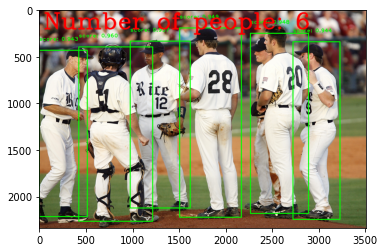

True

In [ ]:
scores = output[0]['scores'].detach().cpu().numpy()
num_people = len(scores[scores > 0.7])

boxes = output[0]['boxes'].detach().cpu().numpy()
boxes = boxes[:num_people]

for i in range(num_people):
  img = cv2.rectangle(img, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), (0, 255, 0), thickness=10)
  img = cv2.putText(img, "score: {:.3f}".format(scores[i]), (boxes[i][0], int(boxes[i][1] - 100)),
                    cv2.FONT_HERSHEY_PLAIN, 4, (0, 255, 0), thickness=5)

plt.imshow(img)
plt.show()

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('sample_pedestrian_detection_output.jpg', img)